In [4]:
import pandas as pd
df = pd.read_csv("reading_measures_corrected.csv", sep="\t")
print(df.shape)
print(df.columns[:20])

(387005, 62)
Index(['subject_id', 'item_id', 'model', 'decoding_strategy', 'TRIAL_ID',
       'word_id', 'word', 'FFD', 'SFD', 'FD', 'FPRT', 'FRT', 'TFT', 'RRT',
       'RPD_inc', 'RPD_exc', 'RBRT', 'Fix', 'FPF', 'RR'],
      dtype='object')


In [6]:
import statsmodels.api as sm

usecols = ["FPRT", "TFT", "surprisal_gpt2", "word_length_without_punct", "zipf_freq"]
df = pd.read_csv("reading_measures_corrected.csv", sep="\t", usecols=usecols)

df = df.dropna()

X = df[["surprisal_gpt2", "word_length_without_punct", "zipf_freq"]]
X = sm.add_constant(X)

# fprt
model_fprt = sm.OLS(df["FPRT"], X).fit()
print(model_fprt.summary())

# tft
model_tft = sm.OLS(df["TFT"], X).fit()
print(model_tft.summary())


                            OLS Regression Results                            
Dep. Variable:                   FPRT   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                 4.410e+04
Date:                Sun, 11 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:57:06   Log-Likelihood:            -2.4936e+06
No. Observations:              387005   AIC:                         4.987e+06
Df Residuals:                  387001   BIC:                         4.987e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

features = ["surprisal_gpt2", "word_length_without_punct", "zipf_freq"]
X = df[features]
y = df["FPRT"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print("r2 fprt:", r2_score(y_test, pred))


r2 fprt: 0.20822926157466637


In [9]:
import pandas as pd

imp = pd.DataFrame({
    "feature": features,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(imp)


                     feature  importance
1  word_length_without_punct    0.446733
0             surprisal_gpt2    0.368678
2                  zipf_freq    0.184588


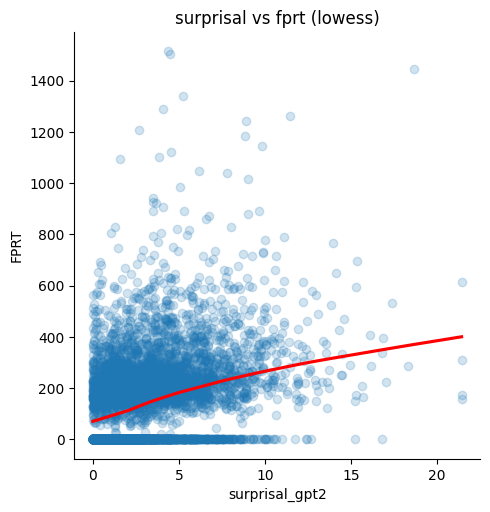

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=df.sample(5000, random_state=42),  # subsample pt viteza
    x="surprisal_gpt2",
    y="FPRT",
    lowess=True,
    scatter_kws={"alpha": 0.2},
    line_kws={"color": "red"}
)
plt.title("surprisal vs fprt (lowess)")
plt.show()


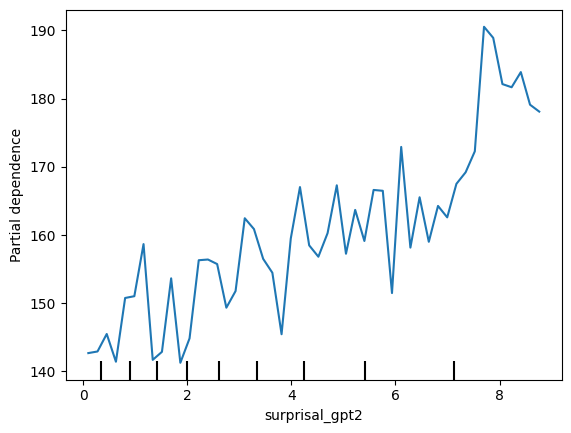

In [13]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    features=["surprisal_gpt2"],
    grid_resolution=50
)
plt.show()


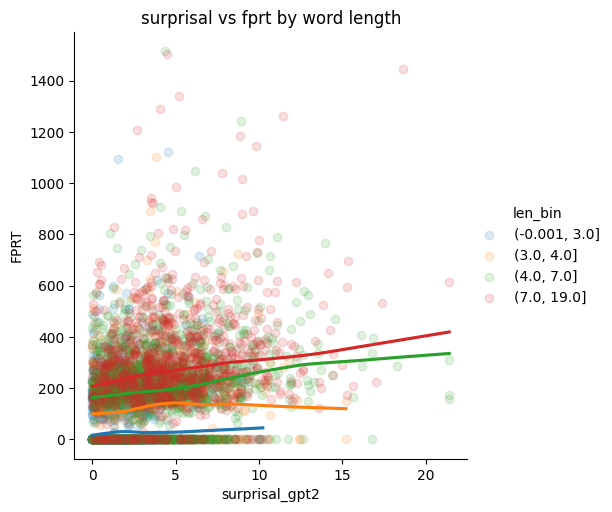

In [14]:
df["len_bin"] = pd.qcut(df["word_length_without_punct"], 4)

sns.lmplot(
    data=df.sample(5000, random_state=42),
    x="surprisal_gpt2",
    y="FPRT",
    hue="len_bin",
    lowess=True,
    scatter_kws={"alpha": 0.15}
)
plt.title("surprisal vs fprt by word length")
plt.show()


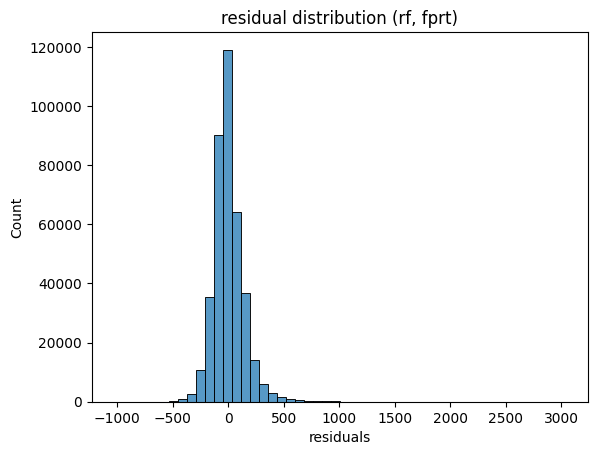

In [15]:
df["fprt_pred"] = rf.predict(X)
df["residuals"] = df["FPRT"] - df["fprt_pred"]

sns.histplot(df["residuals"], bins=50)
plt.title("residual distribution (rf, fprt)")
plt.show()


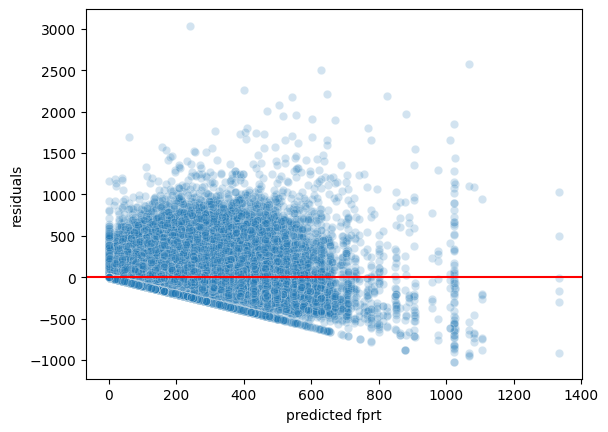

In [16]:
sns.scatterplot(
    x=df["fprt_pred"],
    y=df["residuals"],
    alpha=0.2
)
plt.axhline(0, color="red")
plt.xlabel("predicted fprt")
plt.ylabel("residuals")
plt.show()


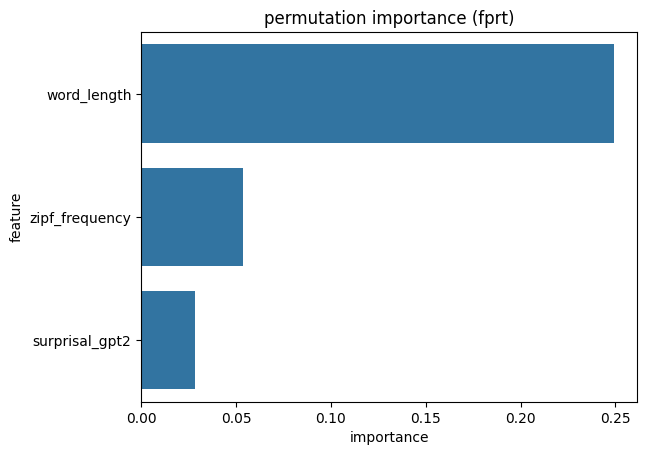

In [17]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_perm = pd.DataFrame({
    "feature": features,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

sns.barplot(data=imp_perm, x="importance", y="feature")
plt.title("permutation importance (fprt)")
plt.show()
